In [ ]:
from Ant_quant import QuantizedActorCriticPolicy
from stable_baselines3 import PPO
import gymnasium as gym
cfg = {
    "quant_act": True,
    "quant_weights": True,
    "activation": "relu",
}
env = gym.make("Ant-v5")
model_path = "/home/ritwik/MuJoCo_Quant/logs_ant/best_model_fixscale_w/best_model.zip"
model = PPO.load(
    model_path,
    env=env,
    custom_objects={
        "policy_class": QuantizedActorCriticPolicy,
        "policy_kwargs": {"cfg": cfg}
    },
    strict=False
)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


RuntimeError: Error(s) in loading state_dict for QuantizedActorCriticPolicy:
	size mismatch for mlp_extractor.policy_net.act1.x_min: copying a param with shape torch.Size([]) from checkpoint, the shape in current model is torch.Size([1]).
	size mismatch for mlp_extractor.policy_net.act1.x_max: copying a param with shape torch.Size([]) from checkpoint, the shape in current model is torch.Size([1]).
	size mismatch for mlp_extractor.policy_net.act1.act_scaling_factor: copying a param with shape torch.Size([]) from checkpoint, the shape in current model is torch.Size([1]).
	size mismatch for mlp_extractor.policy_net.fc1.weight: copying a param with shape torch.Size([128, 105]) from checkpoint, the shape in current model is torch.Size([256, 105]).
	size mismatch for mlp_extractor.policy_net.fc1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for mlp_extractor.policy_net.fc1.weight_integer: copying a param with shape torch.Size([128, 105]) from checkpoint, the shape in current model is torch.Size([256, 105]).
	size mismatch for mlp_extractor.policy_net.fc1.bias_integer: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for mlp_extractor.policy_net.fc2.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for mlp_extractor.policy_net.fc2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for mlp_extractor.policy_net.fc2.weight_integer: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for mlp_extractor.policy_net.fc2.bias_integer: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for mlp_extractor.value_net.0.weight: copying a param with shape torch.Size([128, 105]) from checkpoint, the shape in current model is torch.Size([256, 105]).
	size mismatch for mlp_extractor.value_net.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for mlp_extractor.value_net.2.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for mlp_extractor.value_net.2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for action_net.fc1.weight: copying a param with shape torch.Size([8, 128]) from checkpoint, the shape in current model is torch.Size([8, 256]).
	size mismatch for action_net.fc1.weight_integer: copying a param with shape torch.Size([8, 128]) from checkpoint, the shape in current model is torch.Size([8, 256]).
	size mismatch for action_net.act2.x_min: copying a param with shape torch.Size([]) from checkpoint, the shape in current model is torch.Size([1]).
	size mismatch for action_net.act2.x_max: copying a param with shape torch.Size([]) from checkpoint, the shape in current model is torch.Size([1]).
	size mismatch for action_net.act2.act_scaling_factor: copying a param with shape torch.Size([]) from checkpoint, the shape in current model is torch.Size([1]).
	size mismatch for value_net.weight: copying a param with shape torch.Size([1, 128]) from checkpoint, the shape in current model is torch.Size([1, 256]).

# Load the model

In [105]:
model_path = "/home/ritwik/MuJoCo_Quant/logs_ant/best_model_fixscale_2/best_model.zip"
import torch as th
import zipfile
import io
from Ant_quant import *
# Open the zip and load policy.pth
with zipfile.ZipFile(model_path, "r") as archive:
    with archive.open("policy.pth", "r") as f:
        state_dict = th.load(io.BytesIO(f.read()), map_location="cpu")

state_dict.keys()

odict_keys(['log_std', 'mlp_extractor.policy_net.act1.x_min', 'mlp_extractor.policy_net.act1.x_max', 'mlp_extractor.policy_net.act1.act_scaling_factor', 'mlp_extractor.policy_net.act1.pre_weight_scaling_factor', 'mlp_extractor.policy_net.act1.identity_weight_scaling_factor', 'mlp_extractor.policy_net.fc1.weight', 'mlp_extractor.policy_net.fc1.bias', 'mlp_extractor.policy_net.fc1.fc_scaling_factor', 'mlp_extractor.policy_net.fc1.weight_integer', 'mlp_extractor.policy_net.fc1.bias_integer', 'mlp_extractor.policy_net.act2.x_min', 'mlp_extractor.policy_net.act2.x_max', 'mlp_extractor.policy_net.act2.act_scaling_factor', 'mlp_extractor.policy_net.act2.pre_weight_scaling_factor', 'mlp_extractor.policy_net.act2.identity_weight_scaling_factor', 'mlp_extractor.policy_net.fc2.weight', 'mlp_extractor.policy_net.fc2.bias', 'mlp_extractor.policy_net.fc2.fc_scaling_factor', 'mlp_extractor.policy_net.fc2.weight_integer', 'mlp_extractor.policy_net.fc2.bias_integer', 'mlp_extractor.policy_net.act3.x_mi

# Get the scales and weights

In [106]:
def batch_frexp_refactored(inputs):
    """
    Decompose the scaling factor into mantissa and twos exponent, ensuring:
    - Mantissa lies in [0, 2^16)
    - Exponent remains meaningful (adjusted to match the scaled mantissa)

    Parameters:
    ----------
    inputs: Tensor
        Scaling factor

    Returns:
    -------
    mantissa: Tensor
    exponent: Tensor
    """
    shape_of_input = inputs.size()

    # Flatten the input tensor to a 1D tensor
    inputs = inputs.view(-1)

    # Decompose into mantissa and exponent
    output_m, output_e = np.frexp(inputs.cpu().numpy())

    # Prepare adjusted mantissa and exponent lists
    tmp_m = []
    tmp_e = []

    # Define the bias to scale mantissa to [0, 2^16)
    scale_factor = 16  # 2^16

    for idx, (m, e) in enumerate(zip(output_m, output_e)):
        # Scale mantissa from [0.5, 1) to [0, 2^16)
        int_m_shifted = int(Decimal(m * (2 ** scale_factor)).quantize(Decimal('1'), rounding=decimal.ROUND_HALF_UP))

        # Adjust the exponent to account for the scaling of the mantissa
        e -= scale_factor
        e= e*-1
        e = max(0, min(255, e))
        # Ensure mantissa and exponent are within valid bounds
        if int_m_shifted >= 2 ** 16:  # Cap mantissa at maximum (65535)
            int_m_shifted = 2 ** 16 - 1

        elif inputs[idx] >= 65535:
            int_m_shifted = 65535
            e = 0

        tmp_m.append(int_m_shifted)
        tmp_e.append(e)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # tensor = torch.tensor(0.).to(device)

    return torch.from_numpy(np.array(tmp_m)).to(device).view(shape_of_input), \
           torch.from_numpy(np.array(tmp_e)).to(device).view(shape_of_input)


In [107]:
state_dict.keys()

odict_keys(['log_std', 'mlp_extractor.policy_net.act1.x_min', 'mlp_extractor.policy_net.act1.x_max', 'mlp_extractor.policy_net.act1.act_scaling_factor', 'mlp_extractor.policy_net.act1.pre_weight_scaling_factor', 'mlp_extractor.policy_net.act1.identity_weight_scaling_factor', 'mlp_extractor.policy_net.fc1.weight', 'mlp_extractor.policy_net.fc1.bias', 'mlp_extractor.policy_net.fc1.fc_scaling_factor', 'mlp_extractor.policy_net.fc1.weight_integer', 'mlp_extractor.policy_net.fc1.bias_integer', 'mlp_extractor.policy_net.act2.x_min', 'mlp_extractor.policy_net.act2.x_max', 'mlp_extractor.policy_net.act2.act_scaling_factor', 'mlp_extractor.policy_net.act2.pre_weight_scaling_factor', 'mlp_extractor.policy_net.act2.identity_weight_scaling_factor', 'mlp_extractor.policy_net.fc2.weight', 'mlp_extractor.policy_net.fc2.bias', 'mlp_extractor.policy_net.fc2.fc_scaling_factor', 'mlp_extractor.policy_net.fc2.weight_integer', 'mlp_extractor.policy_net.fc2.bias_integer', 'mlp_extractor.policy_net.act3.x_mi

In [117]:
state_dict['mlp_extractor.policy_net.act2.pre_weight_scaling_factor']

tensor([1.])

In [108]:
Sx = state_dict['mlp_extractor.policy_net.act1.act_scaling_factor']
Sw = state_dict['mlp_extractor.policy_net.fc1.fc_scaling_factor']
Sx1 = state_dict['mlp_extractor.policy_net.act2.act_scaling_factor']
Sw1 = state_dict['mlp_extractor.policy_net.fc2.fc_scaling_factor']
# Sx2 = state_dict['mlp_extractor.policy_net.act3.act_scaling_factor']
Sw2 = state_dict['action_net.fc1.fc_scaling_factor']
Sx2 = state_dict['action_net.act1.act_scaling_factor']
Sw3= state_dict['action_net.fc1.fc_scaling_factor'] 
Sx3 = state_dict['action_net.act2.act_scaling_factor']

In [69]:
Sx3

tensor(0.0124)

In [68]:
state_dict['action_net.act2.x_max']

tensor(1.5380)

In [122]:
import numpy as np
m0, e0 = batch_frexp_refactored(Sx)
m1, e1 = batch_frexp_refactored(Sw*Sx/Sx1)
m2, e2 = batch_frexp_refactored(Sw1*Sx1/Sx2)
m3, e3 = batch_frexp_refactored(Sx2*Sw2/Sx3)

w1 = state_dict['mlp_extractor.policy_net.fc1.weight_integer']
b1 = state_dict['mlp_extractor.policy_net.fc1.bias_integer']
w2 = state_dict['mlp_extractor.policy_net.fc2.weight_integer']
b2 = state_dict['mlp_extractor.policy_net.fc2.bias_integer']
w3 = state_dict['action_net.fc1.weight_integer']
b3 = state_dict['action_net.fc1.bias_integer']

In [110]:
env = gym.make('Ant-v5')
obs = env.reset()

In [34]:
w1.shape

torch.Size([128, 105])

In [119]:
# Forward pass
obs_=env.reset()
# Sx3 = torch.tensor(1/256)

def forward_pass(obs):
    obs_quant = torch.round(torch.tensor(obs)*2**e0/m0).to(torch.float32)
    obs_quant = torch.clip(obs_quant, -127, 127)
    a1 = torch.round((torch.matmul(obs_quant,w1.T)+b1)*m1/2**e1)
    # a1 = torch.relu(a1)
    a1 = torch.clip(a1, 0, 255)
    a2 = torch.round((torch.matmul(a1,w2.T)+b2)*m2/2**e2)
    # a2 = torch.relu(a2)
    a2 = torch.clip(a2, 0, 255)
    a3 = torch.round((torch.matmul(a2,w3.T)+b3)*m3/2**e3)
    a3 = torch.clip(a3, -127, 127)

    return a3




In [121]:
import imageio
timestep=0
obs = env.reset()
total_reward= 0
done = False
frames = []
while not done and timestep < 1000:
    if timestep==0:
        action = forward_pass(obs[0])*Sx3
    else:
        action = forward_pass(obs)*Sx3
    action = action.cpu().numpy()
    # if timestep ==0:
    #     action, _ = model.policy.predict(obs[0], deterministic=True)
    # else:
    #     action, _ = model.policy.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    # frame = env.render(mode="rgb_array")
    # frames.append(frame)
    obs_req = obs
    # break
    done = terminated or truncated
    
    # if done:
        # print(timestep)
    total_reward += reward
    timestep+=1
print(total_reward)

-800.5493025656094


In [98]:
cfg = {
    "quant_act": True,
    "quant_weights": True,
    "activation": "relu",
}
model_path = "/home/ritwik/MuJoCo_Quant/logs_ant/best_model_fixscale/best_model.zip"
model = PPO.load(
    model_path,
    env=env,
    custom_objects={
        "policy_class": QuantizedActorCriticPolicy,
        "policy_kwargs": {"cfg": cfg}
    },
    strict=False
)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


RuntimeError: Error(s) in loading state_dict for QuantizedActorCriticPolicy:
	size mismatch for mlp_extractor.policy_net.act1.x_min: copying a param with shape torch.Size([]) from checkpoint, the shape in current model is torch.Size([1]).
	size mismatch for mlp_extractor.policy_net.act1.x_max: copying a param with shape torch.Size([]) from checkpoint, the shape in current model is torch.Size([1]).
	size mismatch for mlp_extractor.policy_net.act1.act_scaling_factor: copying a param with shape torch.Size([]) from checkpoint, the shape in current model is torch.Size([1]).
	size mismatch for mlp_extractor.policy_net.fc1.weight: copying a param with shape torch.Size([128, 105]) from checkpoint, the shape in current model is torch.Size([256, 105]).
	size mismatch for mlp_extractor.policy_net.fc1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for mlp_extractor.policy_net.fc1.weight_integer: copying a param with shape torch.Size([128, 105]) from checkpoint, the shape in current model is torch.Size([256, 105]).
	size mismatch for mlp_extractor.policy_net.fc1.bias_integer: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for mlp_extractor.policy_net.fc2.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for mlp_extractor.policy_net.fc2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for mlp_extractor.policy_net.fc2.weight_integer: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for mlp_extractor.policy_net.fc2.bias_integer: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for mlp_extractor.value_net.0.weight: copying a param with shape torch.Size([128, 105]) from checkpoint, the shape in current model is torch.Size([256, 105]).
	size mismatch for mlp_extractor.value_net.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for mlp_extractor.value_net.2.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for mlp_extractor.value_net.2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for action_net.fc1.weight: copying a param with shape torch.Size([8, 128]) from checkpoint, the shape in current model is torch.Size([8, 256]).
	size mismatch for action_net.fc1.weight_integer: copying a param with shape torch.Size([8, 128]) from checkpoint, the shape in current model is torch.Size([8, 256]).
	size mismatch for action_net.act2.x_min: copying a param with shape torch.Size([]) from checkpoint, the shape in current model is torch.Size([1]).
	size mismatch for action_net.act2.x_max: copying a param with shape torch.Size([]) from checkpoint, the shape in current model is torch.Size([1]).
	size mismatch for action_net.act2.act_scaling_factor: copying a param with shape torch.Size([]) from checkpoint, the shape in current model is torch.Size([1]).
	size mismatch for value_net.weight: copying a param with shape torch.Size([1, 128]) from checkpoint, the shape in current model is torch.Size([1, 256]).

(600,)


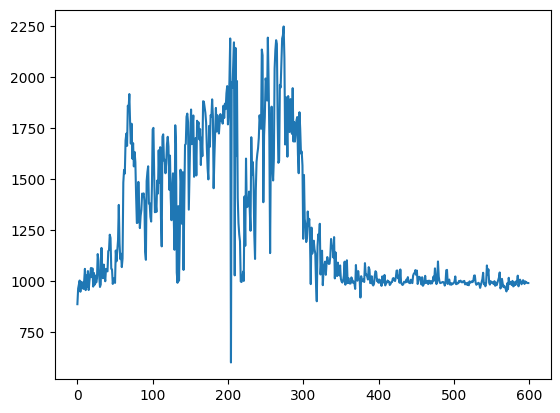

In [33]:
import numpy as np
import matplotlib.pyplot as plt
data = np.load("/home/ritwik/MuJoCo_Quant/logs_ant/results/128_128/evaluations.npz")
print(data['results'][:,0].shape)
plt.plot(data['results'][:,0])

In [48]:
action

array([-0.04891392,  0.01510577, -0.00719322, -0.06617766,  0.06186172,
        0.04028205, -0.09135394, -0.0805641 ], dtype=float32)

In [39]:
obs_quant_save = obs_quant.cpu().numpy().reshape(-1, 1)
a1_save = a1.cpu().numpy().reshape(-1, 1)
a2_save = a2.cpu().numpy().reshape(-1, 1)
a3_save = a3.cpu().numpy().reshape(-1,1)

# 

In [ ]:


w1_save = w1.cpu().numpy()
w2_save = w2.cpu().numpy()
w3_save = w3.cpu().numpy()

b1_save = b1.cpu().numpy().reshape(-1,1)
b2_save = b2.cpu().numpy().reshape(-1,1)
b3_save = b3.cpu().numpy().reshape(-1,1)

In [113]:
obs_quant_save.shape

(105, 1)

In [122]:
m0.reshape(-1,1)

tensor([[39279]])

In [40]:
os.mkdir("Activation")
path1 = "./Activation/"
np.savetxt(path1+"obs_quant.csv", obs_quant_save.T, delimiter=",", fmt="%.6f")
np.savetxt(path1+"a1.csv", a1_save.T, delimiter=",", fmt="%.6f")
np.savetxt(path1+"a2.csv", a2_save.T, delimiter=",", fmt="%.6f")
np.savetxt(path1+"a3.csv", a3_save.T, delimiter=",",fmt="%.6f")

In [170]:
import os
# os.mkdir("Activation")

os.mkdir("Parameters")
path1 = "./Activation/"
path2 = "./Parameters/"
np.savetxt(path1+"obs_quant.csv", obs_quant_save.T, delimiter=",", fmt="%.6f")
np.savetxt(path1+"a1.csv", a1_save.T, delimiter=",", fmt="%.6f")
np.savetxt(path1+"a2.csv", a2_save.T, delimiter=",", fmt="%.6f")
np.savetxt(path1+"a3.csv", a3_save.T, delimiter=",",fmt="%.6f")
np.savetxt(path2+"fc1_weight.csv", w1_save.T, delimiter=",",fmt="%.6f")
np.savetxt(path2+"fc2_weight.csv", w2_save.T, delimiter=",",fmt="%.6f")
np.savetxt(path2+"fc3_weight.csv", w3_save.T, delimiter=",",fmt="%.6f")
np.savetxt(path2+"fc1_bias.csv", b1_save.T, delimiter=",",fmt="%.6f")
np.savetxt(path2+"fc2_bias.csv", b2_save.T, delimiter=",",fmt="%.6f")
np.savetxt(path2+"fc3_bias.csv", b3_save.T, delimiter=",",fmt="%.6f")
# np.save


In [127]:
import os
os.mkdir("Scales")
path = "./Scales/"

np.savetxt(path+"m0.csv", m0.reshape(-1,1).cpu().numpy(), delimiter=",",fmt="%.6f")
np.savetxt(path+"e0.csv", e0.reshape(-1,1).cpu().numpy(), delimiter=",",fmt="%.6f")
np.savetxt(path+"m1.csv", m1.reshape(-1,1).cpu().numpy(), delimiter=",",fmt="%.6f")
np.savetxt(path+"e1.csv", e1.reshape(-1,1).cpu().numpy(), delimiter=",",fmt="%.6f")
np.savetxt(path+"m2.csv", m2.reshape(-1,1).cpu().numpy(), delimiter=",",fmt="%.6f")
np.savetxt(path+"e2.csv", e2.reshape(-1,1).cpu().numpy(), delimiter=",",fmt="%.6f")
np.savetxt(path+"m3.csv", m3.reshape(-1,1).cpu().numpy(), delimiter=",",fmt="%.6f")
np.savetxt(path+"e3.csv", e3.reshape(-1,1).cpu().numpy(), delimiter=",",fmt="%.6f")

In [5]:
import torch
params = torch.load("/home/ritwik/MuJoCo_Quant/logs_ant/best_model_fixscale_1/best_model.zip", map_location="cpu")

RuntimeError: [enforce fail at inline_container.cc:176] . file in archive is not in a subdirectory: data

In [3]:
model.value_net


NameError: name 'model' is not defined